# This notebook is dedicated to CitiBike/Weather/Real Estate EDA 

## Setting Configurations

In [63]:
from pyspark.sql import SparkSession

from pyspark.mllib.stat import Statistics as stat
from pyspark.sql.functions import desc, asc
from pyspark.sql.functions import explode
from pyspark.sql import functions as F
from pyspark.ml import Pipeline
from pyspark.ml.feature import Bucketizer
from pyspark.sql.functions import udf
import numpy as np
import seaborn as sns

from itertools import chain
from pyspark.sql.functions import create_map, lit
from pyspark.mllib.classification import LogisticRegressionWithLBFGS, LogisticRegressionModel
from pyspark.mllib.regression import LabeledPoint
from pyspark.ml.feature import VectorAssembler 
from pyspark.mllib.linalg import Vectors
from pyspark.mllib.evaluation import MulticlassMetrics
from pyspark.ml.feature import StandardScaler
from pyspark.sql.functions import round, col
import seaborn as sb
import matplotlib.pyplot as plt
import pyarrow.parquet as pq

# Necessary for distance calculations
from math import sin, cos, sqrt, atan2, radians    
from pyspark.sql.functions import col, radians, asin, sin, sqrt, cos

# set configurations
from pyspark import SparkConf, SparkContext
from pyspark.sql.types import DoubleType, StringType

import pandas as pd
import os

In [64]:
conf = SparkConf().setMaster("local[*]").setAppName("weatherwork")
sc = SparkContext.getOrCreate(conf=conf)

In [65]:
spark = SparkSession.builder \
        .appName("comm") \
        .getOrCreate()

In [66]:
spark = SparkSession.builder \
        .appName("bike") \
        .getOrCreate()
%matplotlib inline

In [5]:
#Spark session
#spark = SparkSession.builder \
#        .appName("model") \
#        .config("spark.executor.memory", '18g') \
#        .config('spark.executor.cores', '6') \
#        .config('spark.executor.instances', '29') \
#        .getOrCreate()

### Reading in the data

In [67]:
df = spark.read.parquet("/project/ds5559/Summer2021_TeamBike/master_dataset.parquet")

In [7]:
df.show(1)

+--------+----------+--------------+-------------------+--------------------+---------------------+----------+----+------------+--------------------+------------+-------------------+------------------+-------------------+-------+--------+---------+------+------+----------+--------+--------+--------+--------+----------+-------+-------+-------+-------+----------+------------+---+------+-----+--------+------------+----+---------+---------+---------+--------------------+--------------------+--------+------------------+------------------+----------------------+----------------------+----------------------+-------------------+------------------+-------------------+------------------+--------------------+
| Borough|month_year|startStationId|   startStationName|startStationLatitude|startStationLongitude|      date|hour|tripduration|           starttime|endStationId|     endStationName|endStationLatitude|endStationLongitude| bikeid|usertype|birthyear|gender|  temp|feels_like|temp_min|temp_max|p

#### Exploring some variables before altering the dataset 

In [8]:
total = df.count()
df.groupby('gender').count().sort("count").show()
# Gender(Zero=unknown; 1=male; 2=female)... Null? 

df.groupBy("gender") \
  .count() \
  .withColumn('percent', (F.col('count') / total) * 100 ) \
  .show()

+------+--------+
|gender|   count|
+------+--------+
|   0.0| 3742634|
|  null| 7269482|
|   2.0|10880886|
|   1.0|27501218|
+------+--------+

+------+--------+------------------+
|gender|   count|           percent|
+------+--------+------------------+
|   0.0| 3742634| 7.577068733953082|
|  null| 7269482|14.717272587764318|
|   1.0|27501218|55.676996215346655|
|   2.0|10880886|22.028662462935948|
+------+--------+------------------+



The gender variable in this dataset turned out to be not very useful. There were almost 4 million observations that were unknown, and over 7 million null observations. There also was almost 3 times as many males than there were females which made us believe male was some sort of default value. However, when we went in to create a Citibike account, there actually was no default value, and Citibike had changed from asking their customers for their genders, to asking them for their pronouns. With the disparity in the actual data, and the fact that the Citibike changed the question they asked, we decided to drop this variable. 

In [9]:
#df.groupby('birthyear').count().sort("count").show()
# NOT required when signing up; but also no default

df.groupBy("birthyear") \
  .count().sort(desc("birthyear")) \
  .withColumn('percent', (F.col('count') / total) * 100 ) \
  .show()

df.groupBy("birthyear") \
  .count().sort(asc("birthyear")) \
  .withColumn('percent', (F.col('count') / total) * 100 ) \
  .show()

+---------+------+--------------------+
|birthyear| count|             percent|
+---------+------+--------------------+
|   2005.0|     2|4.049056751984341...|
|   2004.0|  1008|0.002040724603000108|
|     2004|  7159| 0.01449359864372795|
|   2003.0|  2115|0.004281877515223441|
|     2003| 37318| 0.07555134993527582|
|   2002.0|  4905|0.009930311684241598|
|     2002| 95942| 0.19423730144944085|
|   2001.0|  7058|0.014289121277752743|
|     2001|174094| 0.35245824308998097|
|   2000.0|  9591|0.019417251654140908|
|     2000|291324|  0.5897937046075431|
|   1999.0|  9384| 0.01899817428031053|
|     1999|339773|  0.6878800798959879|
|   1998.0| 10401| 0.02105711963869457|
|     1998|389344|  0.7882379760222957|
|   1997.0| 16123| 0.03264147100612177|
|     1997|549442|  1.1123609199618902|
|   1996.0| 21771| 0.04407600727372555|
|     1996|813447|  1.6468465338657035|
|   1995.0| 27234| 0.05513600579177078|
+---------+------+--------------------+
only showing top 20 rows

+---------+---

Note: The birthyear variable has birth years that range from 1857 to 2005. For now, we have grouped all of the dates prior to 1940 into ">1940". We will eventually bin these dates in groups of 10. 

In [10]:
df.groupby('bikeid').count().sort("count").show()
# Gender(Zero=unknown; 1=male; 2=female)... Null? 

df.groupBy("bikeid") \
  .count().sort(desc("count")) \
  .withColumn('percent', (F.col('count') / total) * 100 ) \
  .show()

+-------+-----+
| bikeid|count|
+-------+-----+
|42938.0|    1|
|37967.0|    1|
|35605.0|    1|
|44779.0|    1|
|29515.0|    1|
|37952.0|    1|
|44790.0|    1|
|44769.0|    1|
|38002.0|    1|
|49847.0|    1|
|42068.0|    1|
|44752.0|    1|
|31041.0|    1|
|34839.0|    1|
|45335.0|    1|
|42497.0|    1|
|45441.0|    1|
|26181.0|    1|
|44329.0|    1|
|34924.0|    1|
+-------+-----+
only showing top 20 rows

+-------+-------+--------------------+
| bikeid|  count|             percent|
+-------+-------+--------------------+
|   null|7269482|  14.717272587764318|
|34000.0|   5485|0.011104538142317056|
|33800.0|   5480|0.011094415500437094|
|34088.0|   5415|0.010962821155997605|
|34187.0|   5361|0.010853496623694028|
|34059.0|   5313|0.010756319261646403|
|33892.0|   5307| 0.01074417209139045|
|33973.0|   5284| 0.01069760793874263|
|34266.0|   5250|0.010628773973958897|
|33915.0|   5225|0.010578160764559091|
|34090.0|   5211|0.010549817367295202|
|34396.0|   5207|0.010541719253791233|
|3419

In [11]:
df.groupby('usertype').count().sort("count").show()
#User Type(Customer = 24-hour pass or 3-day pass user; Subscriber = Annual Member)

+----------+--------+
|  usertype|   count|
+----------+--------+
|    member| 5483991|
|  Customer| 7124164|
|Subscriber|36786065|
+----------+--------+



### Changing the dataset

#### Adding the "good" and "bad" weather variables

In [68]:

# load the broadcast variables from csv
# duration by station and month
durationByStationMonth_filepath = "/project/ds5559/Summer2021_TeamBike/broadcastMonthStationDuration.csv"
df_durationByStationMonth = spark.read.csv(durationByStationMonth_filepath).rdd.collectAsMap()
#for x in list(df_durationByStationMonth)[0:3]:
#    print ("key {}, value {} ".format(x,  df_durationByStationMonth[x]))
bc_durationByStationMonth = sc.broadcast(df_durationByStationMonth)
# duration by station and month and good/bad weather
goodBadDurationByStationMonth_filepath = "/project/ds5559/Summer2021_TeamBike/broadcastMonthStationWeatherGoodBadDuration.csv"
df_goodBadDurationByStationMonth = spark.read.csv(goodBadDurationByStationMonth_filepath).rdd.collectAsMap()
#for x in list(df_goodBadDurationByStationMonth)[0:3]:
#    print ("key {}, value {} ".format(x,  df_goodBadDurationByStationMonth[x]))
bc_goodBadDurationByStationMonth = sc.broadcast(df_goodBadDurationByStationMonth)
# to add columns with the GOOD and bad weather duration indexes
from pyspark.sql.functions import col
@udf(returnType=DoubleType())
def setweatherGoodDurationIndex(month : str, startStationName : str):
    averageDuration = bc_durationByStationMonth.value.get(month + "-" + startStationName)
    goodDuration= bc_goodBadDurationByStationMonth.value.get(month + "-" + startStationName + "GOOD")
    if goodDuration is None:
        # if the dictionary doesn't have a good duration value, use the average trips
        goodDuration = averageDuration
    index_value = float(goodDuration) / float(averageDuration)
    return index_value
@udf(returnType=DoubleType())
def setweatherBadDurationIndex(month : str, startStationName : str):
    averageDuration = bc_durationByStationMonth.value.get(month + "-" + startStationName)
    badDuration= bc_goodBadDurationByStationMonth.value.get(month + "-" + startStationName + "BAD")
    if badDuration is None:
        # if the dictionary doesn't have a bad duration value, use the average trips
        badDuration = averageDuration
    index_value = float(badDuration) / float(averageDuration)
    return index_value
# load the standard data file with only the columns I am interested in using:
# THE IS THE FINAL DATA FILE
file = "/project/ds5559/Summer2021_TeamBike/master_dataset.parquet" 
df = spark.read.parquet(file)
df = df.withColumn("weatherGoodDurationIndex", setweatherGoodDurationIndex(col("month"), col("startStationName")))
df = df.withColumn("weatherBadDurationIndex", setweatherBadDurationIndex(col("month"), col("startStationName")))


#### Droping the gender variable
* For this analysis, we decided to drop the gender variable. the first reason was because there were over 7 million null values and almost 4 million unknown values. The second reason was after actually signing up for a CitiBike account to see what was defaulted gender is set to, I noticed it required a pronoun instead of a gender. At this point we thought this variable was moot to the analysis. 

In [69]:
df = df.drop(F.col("gender"))

In [70]:
#print(len(df.columns))
#df.printSchema()

#### Changing usertype variable observations
* A couple of years ago, CitiBike started referring to their annual subscripbers as a "member" when they used to be called a "subscriber" to make this more simple, we decided to group both the "members" and "subscribers" into one observation type called "annual", and changed the original "customer" to "daily. 

In [71]:
userDict = {'member':'annual','Subscriber':'annual','Customer':'daily'}
df = df.replace(userDict,subset=['usertype'])

In [72]:
df.select(['usertype']).show()
#df.printSchema()

+--------+
|usertype|
+--------+
|   daily|
|  annual|
|   daily|
|   daily|
|  annual|
|  annual|
|  annual|
|   daily|
|   daily|
|  annual|
|  annual|
|  annual|
|   daily|
|  annual|
|  annual|
|  annual|
|   daily|
|  annual|
|   daily|
|  annual|
+--------+
only showing top 20 rows



In [73]:
df.groupby('usertype').count().sort("count").show()
#User Type(Customer = 24-hour pass or 3-day pass user; Subscriber = Annual Member)

+--------+--------+
|usertype|   count|
+--------+--------+
|   daily| 7124164|
|  annual|42270056|
+--------+--------+



#### Changing tripduration variable from seconds to minutes
* Minutes were easier for us to take a  quick look at data points and understand how long a bike ride was, but we could not do this with seconds so we converted between the two. After I added the tripduration_minute vairable, I was able to drop the orginal tripduration variable. We also decided to bin anything that was over 8 hours into one observation type. We did this because unless you are working all day and decide to lock the bike up not at a station, it would be rare for someone to have a bike for longer that 8 hours.  

In [74]:
#df.select('tripduration').describe().show() # negatives
#df.groupby('tripduration').count().sort(asc("tripduration")).show(250)

# need to drop negative seconds?
df = df.withColumn("tripduration_minute", (df.tripduration / 60))

df.select('tripduration_minute').describe().show()

#df = df.withColumn("tripduration_hour", (df.tripduration_minute / 60))

#df.select('tripduration_hour').describe().show()

+-------+-------------------+
|summary|tripduration_minute|
+-------+-------------------+
|  count|           49394220|
|   mean| 18.305129223284123|
| stddev| 204.05231864630437|
|    min|           -10008.9|
|    max|          165074.55|
+-------+-------------------+



In [75]:
df = df.drop(F.col("tripduration"))

In [76]:


df.filter(F.col("tripduration_minute") <= 0).count()

8861

In [77]:
df.filter(col("tripduration_minute") > 480).count()

44387

In [78]:
#df = df.filter(((F.col("tripduration_minute") <= 0)))
#df1=df.where("tripduration_minute <= 0")
#df_orders1.show()

df = df.withColumn("tripduration_minute", F.when(F.col("tripduration_minute") > 0, F.col("tripduration_minute")).otherwise("0"))

#df.groupby('tripduration_minute').count().sort(asc("tripduration_minute")).show(10)
#df.groupby('tripduration_minute').count().sort(desc("tripduration_minute")).show(10)

#df.filter(col("tripduration_minute") >= 480).count()
#df = df.withColumn("tripduration_minute", F.when(F.col("tripduration_minute") < 480, F.col("tripduration_minute")).otherwise("0"))



In [79]:
df = df.withColumn("tripduration_minute", F.when(F.col("tripduration_minute") < 480, F.col("tripduration_minute")).otherwise("0.0"))
#df.groupby('tripduration_minute').count().sort(desc("tripduration_minute")).show(10)

In [80]:
#df.groupby('tripduration_minute').count().sort(desc("tripduration_minute")).show(10)
df.groupby('tripduration_minute').count().sort(asc('tripduration_minute')).show(10)

+--------------------+-----+
| tripduration_minute|count|
+--------------------+-----+
|                   0| 8861|
|                 0.0|44389|
|0.016666666666666666| 1199|
| 0.03333333333333333| 2686|
|                0.05| 5698|
| 0.06666666666666667| 4433|
| 0.08333333333333333| 2978|
|                 0.1| 2604|
| 0.11666666666666667| 2434|
| 0.13333333333333333| 2319|
+--------------------+-----+
only showing top 10 rows




#### Adding distances

In [81]:
# radius of earth in miles
R = 3963.0

#Convert start/end latitude and longitude from degrees to Radians
df = df.withColumn("startRadLat", radians(df.startStationLatitude)) \
       .withColumn("endRadLat", radians(df.endStationLatitude)) \
       .withColumn("startRadLong", radians(df.startStationLongitude)) \
       .withColumn("endRadLong", radians(df.endStationLongitude))

df.select(df.startRadLat,df.endRadLat,df.startRadLong,df.endRadLong).show(5,False)

+------------------+------------------+-------------------+-------------------+
|startRadLat       |endRadLat         |startRadLong       |endRadLong         |
+------------------+------------------+-------------------+-------------------+
|0.7099873523967277|0.7099873523967277|-1.2912214593940174|-1.2912214593940174|
|0.7102313878234002|0.7108809377608699|-1.2910007792652636|-1.2915272517254752|
|0.7105313146268409|0.7099391987626652|-1.29093715555631  |-1.2908386765749968|
|0.7113661947943947|0.7109956472570291|-1.291032165695735 |-1.291370736008677 |
|0.7107304261512315|0.7109660489163764|-1.2916783473222815|-1.2916279617611712|
+------------------+------------------+-------------------+-------------------+
only showing top 5 rows



In [82]:
df = df.withColumn("diffRadLat", (df.startRadLat-df.endRadLat)) \
       .withColumn("diffRadLong", (df.startRadLong-df.endRadLong)) \
       .withColumn("diffLat", (df.startStationLatitude-df.endStationLatitude)) \
       .withColumn("diffLong", (df.startStationLongitude-df.endStationLongitude))

df = df.withColumn("crowDist", asin(sqrt((sin(df.diffRadLat/2))**2 + (cos(df.startRadLat) * cos(df.endRadLat)) * (sin(df.diffRadLong/2))**2)) * 2 * R)

In [83]:
df = df.withColumn("verticalDist", asin(sqrt((sin(df.diffRadLat/2))**2)) * 2 * R)
df = df.withColumn("horizontalDist", asin(sqrt((sin(df.diffRadLong/2))**2)) * 2 * R)
df = df.withColumn("manhattanDist", (df.horizontalDist + df.verticalDist))

#### Birthyear variable
* This variable is interesting because some of the dates that the riders mentioned were their birthday fall in the early 1800s. To mediate with this concern, we binned the data prior to 1940 into one variable type. 

In [84]:
#df.groupby('birthyear').count().sort("count").show()
# NOT required when signing up; but also no default
#total = df.count()
#df.groupBy("birthyear") 
#  .count().sort(desc("count")) \
#  .withColumn('percent', round((F.col('count') / total) * 100,2 )) \
#  .show()

#df.groupBy("birthyear") \
#  .count().sort(asc("birthyear")) \
#  .withColumn('percent', (F.col('count') / total) * 100 ) \
#  .show()
# has birth years in from the 1800's

#df = df.withColumn("birthyear", F.when(F.col("birthyear") > 1940, F.col("birthyear")).otherwise(">1940"))#

#df.groupBy("birthyear") \
#  .count().sort(desc("count")) \
#  .withColumn('percent', round((F.col('count') / total) * 100,2 )) \
#  .show()

#df.groupBy("birthyear") \
#  .count().sort(asc("count")) \
#  .withColumn('percent', round((F.col('count') / total) * 100,2 )) \
#  .show()
df = df.drop(F.col("birthyear"))

In [29]:
from pyspark.sql.functions import col,isnan, when, count
df_ColumnsBike=["Borough","month_year","startStationId","startStationName","startStationLatitude","startStationLongitude","date","hour","starttime","endStationId","endStationName","endStationLatitude","endStationLongitude","bikeid","usertype", 
               "tripduration_minute", "startRadLat","endRadLat", "diffRadLat", "diffRadLong", "diffLat", "diffLong", "crowDist","verticalDist","horizontalDist","manhattanDist"]


df.select([col for col in df.columns])


df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df_ColumnsBike]).show()

+-------+----------+--------------+----------------+--------------------+---------------------+----+----+---------+------------+--------------+------------------+-------------------+-------+--------+-------------------+-----------+---------+----------+-----------+-------+--------+--------+------------+--------------+-------------+
|Borough|month_year|startStationId|startStationName|startStationLatitude|startStationLongitude|date|hour|starttime|endStationId|endStationName|endStationLatitude|endStationLongitude| bikeid|usertype|tripduration_minute|startRadLat|endRadLat|diffRadLat|diffRadLong|diffLat|diffLong|crowDist|verticalDist|horizontalDist|manhattanDist|
+-------+----------+--------------+----------------+--------------------+---------------------+----+----+---------+------------+--------------+------------------+-------------------+-------+--------+-------------------+-----------+---------+----------+-----------+-------+--------+--------+------------+--------------+-------------+
|

In [117]:
df = df.filter(df.endStationName.isNotNull())
df = df.filter(df.endStationLatitude.isNotNull())
df = df.filter(df.endStationLongitude.isNotNull())
df = df.filter(df.endRadLat.isNotNull())
df = df.filter(df.diffRadLat.isNotNull())
df = df.filter(df.diffRadLong.isNotNull())
df = df.filter(df.diffLat.isNotNull())
df = df.filter(df.diffLong.isNotNull())
df = df.filter(df.crowDist.isNotNull())
df = df.filter(df.verticalDist.isNotNull())
df = df.filter(df.horizontalDist.isNotNull())
df = df.filter(df.manhattanDist.isNotNull())

df10 = df

In [62]:
df.printSchema()

root
 |-- date: string (nullable = true)
 |-- temp: double (nullable = true)
 |-- feels_like: double (nullable = true)
 |-- pressure: long (nullable = true)
 |-- humidity: long (nullable = true)
 |-- wind_speed: double (nullable = true)
 |-- rain_3h: double (nullable = true)
 |-- precip: string (nullable = true)
 |-- feels_like: double (nullable = true)
 |-- humidity: long (nullable = true)
 |-- wind_speed: double (nullable = true)
 |-- clouds_all: long (nullable = true)
 |-- precip: string (nullable = true)



In [32]:
df.select([col for col in df.columns])


df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df_ColumnsBike]).show()

+-------+----------+--------------+----------------+--------------------+---------------------+----+----+---------+------------+--------------+------------------+-------------------+-------+--------+-------------------+-----------+---------+----------+-----------+-------+--------+--------+------------+--------------+-------------+
|Borough|month_year|startStationId|startStationName|startStationLatitude|startStationLongitude|date|hour|starttime|endStationId|endStationName|endStationLatitude|endStationLongitude| bikeid|usertype|tripduration_minute|startRadLat|endRadLat|diffRadLat|diffRadLong|diffLat|diffLong|crowDist|verticalDist|horizontalDist|manhattanDist|
+-------+----------+--------------+----------------+--------------------+---------------------+----+----+---------+------------+--------------+------------------+-------------------+-------+--------+-------------------+-----------+---------+----------+-----------+-------+--------+--------+------------+--------------+-------------+
|

In [33]:
from pyspark.sql.functions import col,isnan, when, count
df_ColumnsWeather = ["temp","feels_like","temp_min","temp_max","pressure","humidity","wind_speed","rain_1h","rain_3h","snow_1h","snow_3h",
                     "clouds_all","weather_main","dow","day","month","time_bin","peak_commute","year","3h_precip","1h_precip","precip",
                     "weatherGoodDurationIndex","weatherBadDurationIndex"]

df.select([col for col in df.columns])


df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df_ColumnsWeather]).show()


+----+----------+--------+--------+--------+--------+----------+-------+-------+-------+-------+----------+------------+---+---+-----+--------+------------+----+---------+---------+------+------------------------+-----------------------+
|temp|feels_like|temp_min|temp_max|pressure|humidity|wind_speed|rain_1h|rain_3h|snow_1h|snow_3h|clouds_all|weather_main|dow|day|month|time_bin|peak_commute|year|3h_precip|1h_precip|precip|weatherGoodDurationIndex|weatherBadDurationIndex|
+----+----------+--------+--------+--------+--------+----------+-------+-------+-------+-------+----------+------------+---+---+-----+--------+------------+----+---------+---------+------+------------------------+-----------------------+
|   0|         0|       0|       0|       0|       0|         0|      0|      0|      0|      0|         0|           0|  0|  0|    0|       0|           0|   0|        0|        0|     0|                       0|                      0|
+----+----------+--------+--------+--------+----

In [34]:
from pyspark.sql.functions import col,isnan, when, count
df_ColumnsHouse=["zipcodes","avg_days_on_market","avg_discount_share","avg_median_sales_price","avg_median_asking_sale","avg_median_asking_rent",
                 "avg_price_cut_share","avg_sales_volume","avg_sales_inventory","avg_rent_inventory","avg_sales_list_ratio"]
df.select([col for col in df.columns])


df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df_ColumnsHouse]).show()

+--------+------------------+------------------+----------------------+----------------------+----------------------+-------------------+----------------+-------------------+------------------+--------------------+
|zipcodes|avg_days_on_market|avg_discount_share|avg_median_sales_price|avg_median_asking_sale|avg_median_asking_rent|avg_price_cut_share|avg_sales_volume|avg_sales_inventory|avg_rent_inventory|avg_sales_list_ratio|
+--------+------------------+------------------+----------------------+----------------------+----------------------+-------------------+----------------+-------------------+------------------+--------------------+
|  211345|                 0|                 0|                     0|                     0|                     0|                  0|               0|                  0|                 0|                   0|
+--------+------------------+------------------+----------------------+----------------------+----------------------+-------------------+---

#### Taking a sample of the data to turn it into a pandas dataframe for visualizations

In [35]:
df1 = df\
.select("Borough","date", "usertype", "feels_like", "tripduration_minute", "weatherGoodDurationIndex","weatherBadDurationIndex")


In [36]:
df2 = df1.sample(0.05)
df3 = df1.sample(0.01)

In [37]:
df2.printSchema()

root
 |-- Borough: string (nullable = true)
 |-- date: string (nullable = true)
 |-- usertype: string (nullable = true)
 |-- feels_like: double (nullable = true)
 |-- tripduration_minute: string (nullable = true)
 |-- weatherGoodDurationIndex: double (nullable = true)
 |-- weatherBadDurationIndex: double (nullable = true)



In [38]:
#df2.count()
df2.count()

2467548

In [39]:
pandasdf = df2.toPandas()

In [40]:
pandasdf2 = df3.toPandas()

In [41]:
dataTypeSeries = pandasdf.dtypes
dataTypeSeries

Borough                      object
date                         object
usertype                     object
feels_like                  float64
tripduration_minute          object
weatherGoodDurationIndex    float64
weatherBadDurationIndex     float64
dtype: object

In [42]:
dataTypeSeries2 = pandasdf2.dtypes
dataTypeSeries2

Borough                      object
date                         object
usertype                     object
feels_like                  float64
tripduration_minute          object
weatherGoodDurationIndex    float64
weatherBadDurationIndex     float64
dtype: object

### Required EDA

A lot of our main dataset is categorical data, or in numerical format, but acts like categorical data like a date and coordinates. It does not make sense to take a statistical summary of a coordinate, date, or even an ID number.  

In [118]:
df.count() # Number of Records

49380335

In [119]:
print(len(df10.columns)) # Number of variables

65


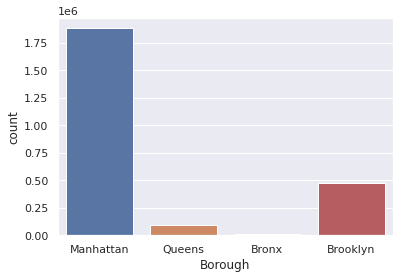

In [49]:
sns.set_theme(style="darkgrid")
ax = sns.countplot(x="Borough", data=pandasdf)

In [120]:
total = df10.count()

df10.groupBy("Borough") \
  .count() \
  .withColumn('percent', round((F.col('count') / total) * 100, 2)) \
  .show()

# Note: Manhattan represents 76.3% of the data and Brooklyn represents 19.38%

+---------+--------+-------+
|  Borough|   count|percent|
+---------+--------+-------+
|   Queens| 1848471|   3.74|
| Brooklyn| 9572096|  19.38|
|Manhattan|37679125|   76.3|
|    Bronx|  280643|   0.57|
+---------+--------+-------+



In [121]:
count_df = df10.select(F.date_format('date','yyyy-MM-dd').alias('day')).groupby('day').count()
count_df.show()

+----------+-----+
|       day|count|
+----------+-----+
|2020-02-26|44503|
|2019-08-08|68714|
|2019-08-22|60527|
|2019-08-23|54493|
|2020-04-13|12394|
|2020-06-24|55850|
|2019-09-29|61919|
|2019-08-31|52390|
|2019-04-25|48615|
|2018-12-31|15405|
|2020-06-08|51073|
|2020-11-12|46182|
|2020-09-12|82785|
|2018-08-23|59918|
|2021-04-06|76015|
|2020-06-20|67686|
|2020-06-22|50198|
|2020-01-05|23003|
|2019-04-08|61904|
|2019-04-26|46301|
+----------+-----+
only showing top 20 rows



In [122]:
count_df2 = df10.select(F.date_format('date','yyyy').alias('year')).groupby('year').count()
count_df2.show()

+----+--------+
|year|   count|
+----+--------+
|2020|16813026|
|2019|17500827|
|2018| 6892454|
|2021| 8174028|
+----+--------+



In [123]:
pandasdf4 = count_df2.toPandas()

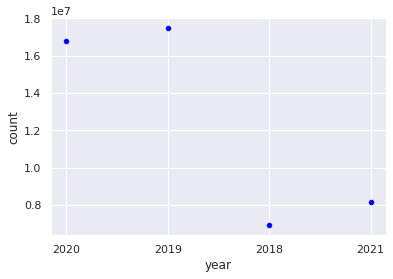

In [124]:
plot = pandasdf4.plot.scatter(x = 'year', y = 'count', c = 'blue')

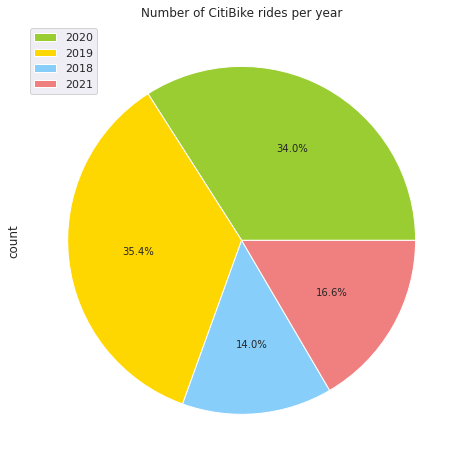

In [91]:
colors = ['yellowgreen', 'gold', 'lightskyblue', 'lightcoral']
labels = '2020', '2019', '2018', '2021'
plot = pandasdf4.plot.pie(y='count', colors=colors, figsize=(8,8), autopct='%1.1f%%', labels=None)
plt.title("Number of CitiBike rides per year")
plt.legend(labels)

In [125]:
count_df2 = df10.withColumn('years',F.year(F.to_timestamp('date', 'yyyy-MM-dd')))

In [93]:
l1 = [('13/08/2010',342),('6/10/2011',334),('27/11/2011',269),('12/01/2012',303),('22/02/2012',286),('31/07/2012',276),('25/04/2013',222)]
dfl1 =  spark.createDataFrame(l1).toDF("dates","sum")

In [126]:
df10.groupBy("startStationId", "startStationName") \
  .count().sort(desc('count')) \
  .withColumn('percent', round((F.col('count') / total) * 100, 2)) \
  .show()

+--------------+--------------------+------+-------+
|startStationId|    startStationName| count|percent|
+--------------+--------------------+------+-------+
|         519.0|Pershing Square N...|238157|   0.48|
|         497.0|  E 17 St & Broadway|186565|   0.38|
|         402.0|  Broadway & E 22 St|173650|   0.35|
|         435.0|     W 21 St & 6 Ave|173176|   0.35|
|         285.0|  Broadway & E 14 St|168102|   0.34|
|         426.0|West St & Chamber...|155825|   0.32|
|         499.0|  Broadway & W 60 St|152965|   0.31|
|         490.0|     8 Ave & W 33 St|147490|    0.3|
|         358.0|Christopher St & ...|145180|   0.29|
|         514.0|    12 Ave & W 40 St|144861|   0.29|
|         459.0|    W 20 St & 11 Ave|142149|   0.29|
|         477.0|     W 41 St & 8 Ave|138817|   0.28|
|         379.0|     W 31 St & 7 Ave|130071|   0.26|
|         523.0|     W 38 St & 8 Ave|127524|   0.26|
|         491.0|E 24 St & Park Ave S|125122|   0.25|
|         504.0|     1 Ave & E 16 St|124833|  

In [96]:
df10.groupBy("endStationId", "endStationName") \
  .count().sort(desc('count')) \
  .withColumn('percent', round((F.col('count') / total) * 100,2)) \
  .show()
# Park Ave. near emp. state building

+------------+--------------------+------+-------+
|endStationId|      endStationName| count|percent|
+------------+--------------------+------+-------+
|       519.0|Pershing Square N...|256944|   0.52|
|       497.0|  E 17 St & Broadway|230983|   0.47|
|       435.0|     W 21 St & 6 Ave|227392|   0.46|
|       426.0|West St & Chamber...|222072|   0.45|
|       402.0|  Broadway & E 22 St|221770|   0.45|
|       514.0|    12 Ave & W 40 St|196134|    0.4|
|       285.0|  Broadway & E 14 St|193524|   0.39|
|       499.0|  Broadway & W 60 St|190172|   0.39|
|       358.0|Christopher St & ...|189280|   0.38|
|      3255.0|     8 Ave & W 31 St|188384|   0.38|
|       490.0|     8 Ave & W 33 St|172919|   0.35|
|       293.0|Lafayette St & E ...|171450|   0.35|
|      3641.0|  Broadway & W 25 St|169475|   0.34|
|      3141.0|     1 Ave & E 68 St|166474|   0.34|
|      3435.0|Grand St & Elizab...|164345|   0.33|
|       368.0|  Carmine St & 6 Ave|162165|   0.33|
|       151.0|Cleveland Pl & Sp

In [97]:
#df.groupBy("bikeid") \
#  .count().sort(desc('count')) \
#  .withColumn('percent', (F.col('count') / total) * 100) \
#  .show()

#Possible for bikes to have no ID... doesnt make sense to keep this 

In [127]:
df10.select('tripduration_minute').describe().show() # negatives

+-------+-------------------+
|summary|tripduration_minute|
+-------+-------------------+
|  count|           49380335|
|   mean| 15.421320367375605|
| stddev| 16.780753226260074|
|    min|                  0|
|    max|  99.98333333333333|
+-------+-------------------+



In [128]:
df10.select('hour').describe().show()

+-------+------------------+
|summary|              hour|
+-------+------------------+
|  count|          49380335|
|   mean|14.008320356676398|
| stddev|  4.78132792823245|
|    min|                 0|
|    max|                23|
+-------+------------------+



In [129]:
#df_vis = pd.DataFrame(data=pandasdf, columns=['tripduration_minute','feels_like']);

#df_vis.plot.scatter(x='tripduration_minute', y='feels_like', title= "Scatter plot between two variables X and Y");

#plt.show()


#sb.scatterplot(data = pandasdf2(x='tripduration_minute', y = 'feels_like').set_title("test"))
#plt.show()

In [130]:
df10.select('feels_like').describe().show() 

+-------+------------------+
|summary|        feels_like|
+-------+------------------+
|  count|          49380335|
|   mean|  56.7457723014488|
| stddev|20.941480358416648|
|    min|           -11.398|
|    max|             107.6|
+-------+------------------+



In [131]:
df10.select('humidity').describe().show() 

+-------+------------------+
|summary|          humidity|
+-------+------------------+
|  count|          49380335|
|   mean| 61.77208909174067|
| stddev|20.422485031052133|
|    min|                 7|
|    max|               100|
+-------+------------------+



In [132]:
df10.select('avg_days_on_market').describe().show()
df10.groupby(round('avg_median_sales_price', 2), 'year', 'zipcodes').count().sort(desc("count")).show()

+-------+------------------+
|summary|avg_days_on_market|
+-------+------------------+
|  count|          49380335|
|   mean|  89.4626538266957|
| stddev|  11.6097304917609|
|    min| 60.79050759965584|
|    max|117.91532458907518|
+-------+------------------+

+--------------------------------+----+--------+------+
|round(avg_median_sales_price, 2)|year|zipcodes| count|
+--------------------------------+----+--------+------+
|                      1025191.29|2019|   10011|122068|
|                      1093787.33|2020|   10002|116297|
|                      1133273.42|2021|   10009|115913|
|                      1133273.42|2021|   10002|115793|
|                      1133273.42|2021|   10003|113692|
|                      1133273.42|2021|   10019|113481|
|                      1008986.98|2019|   10011|113454|
|                      1023422.69|2019|   10011|111917|
|                      1002035.14|2020|   10002|107672|
|                       953360.34|2019|   10011|106963|
|         

In [ ]:
df10.select(round('avg_median_sales_price', 2)).describe().show() # SURPRISE... years 2017 - 2021?
df10.groupby(round('avg_median_sales_price', 2), 'year', 'zipcodes').count().sort(desc("count")).show()

In [ ]:
df10.select('avg_median_asking_sale').describe().show() 
df10.groupby(round('avg_median_asking_sale', 2), 'year', 'zipcodes').count().sort(desc("count")).show()

In [ ]:
time_vs_crow = df10.select(round('tripduration_minute', 2), round('manhattanDist',2),round('crowDist', 2)).show()

In [ ]:
columns = df10.columns
print(columns)

In [ ]:
# MODEL

In [ ]:
#df10.printSchema()

In [110]:
df1 = df10.select('date','temp','feels_like','pressure','humidity','wind_speed','rain_3h', 'precip')

In [111]:
from pyspark.sql.functions import *
df1 = df1.withColumn('precip', regexp_replace('precip', 'no_precip', '0'))
df1 = df1.withColumn('precip', regexp_replace('precip', 'precip', '1'))
df1.show(10)

+----------+------+----------+--------+--------+----------+-------+------+
|      date|  temp|feels_like|pressure|humidity|wind_speed|rain_3h|precip|
+----------+------+----------+--------+--------+----------+-------+------+
|2020-06-01|64.292|     57.38|    1018|      43|      3.93|    0.0|     0|
|2020-06-01|64.292|     57.38|    1018|      43|      3.93|    0.0|     0|
|2020-06-01|64.292|     57.38|    1018|      43|      3.93|    0.0|     0|
|2020-06-01|64.292|     57.38|    1018|      43|      3.93|    0.0|     0|
|2020-06-01|64.292|     57.38|    1018|      43|      3.93|    0.0|     0|
|2020-06-01|64.292|     57.38|    1018|      43|      3.93|    0.0|     0|
|2020-06-01|64.292|     57.38|    1018|      43|      3.93|    0.0|     0|
|2020-06-01|64.292|     57.38|    1018|      43|      3.93|    0.0|     0|
|2020-06-01|64.292|     57.38|    1018|      43|      3.93|    0.0|     0|
|2020-06-01|64.292|     57.38|    1018|      43|      3.93|    0.0|     0|
+----------+------+------

In [112]:
count_df = df1.select(F.date_format('date','yyyy-MM-dd').alias('day')).groupby('day').count()
count_df.show(2)

+----------+-----+
|       day|count|
+----------+-----+
|2020-02-26|44503|
|2019-08-08|68714|
+----------+-----+
only showing top 2 rows



In [113]:
df1 = df1.dropDuplicates(['date'])
df1.show(2)

+----------+------+----------+--------+--------+----------+-------+------+
|      date|  temp|feels_like|pressure|humidity|wind_speed|rain_3h|precip|
+----------+------+----------+--------+--------+----------+-------+------+
|2019-08-08|70.664|    76.748|    1009|     100|       1.5|    0.0|     1|
|2019-08-22|77.972|    87.224|    1011|      94|      1.39|    0.0|     0|
+----------+------+----------+--------+--------+----------+-------+------+
only showing top 2 rows



In [114]:
df1 = df1.join(count_df,df1.date ==  count_df.day,"inner")

In [115]:
df1.show(2)

+----------+------+----------+--------+--------+----------+-------+------+----------+-----+
|      date|  temp|feels_like|pressure|humidity|wind_speed|rain_3h|precip|       day|count|
+----------+------+----------+--------+--------+----------+-------+------+----------+-----+
|2019-08-08|70.664|    76.748|    1009|     100|       1.5|    0.0|     1|2019-08-08|68714|
|2019-08-22|77.972|    87.224|    1011|      94|      1.39|    0.0|     0|2019-08-22|60527|
+----------+------+----------+--------+--------+----------+-------+------+----------+-----+
only showing top 2 rows

